In [1]:
#### Begin notebook
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import obspy
import datetime
from sklearn.linear_model import LinearRegression
import scipy.stats

from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels. api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import linregress

In [2]:
#Generate catalog of earthquakes

#NORTHERN CALIFORNIA

from obspy.core.utcdatetime import UTCDateTime

from obspy.clients.fdsn import Client
client = Client("USGS")
t1 = UTCDateTime("2019-01-01T00:00:00")
t2 = UTCDateTime("2021-01-01T00:00:00")
min_lat = 36.5
max_lat = 38
min_long = -123
max_long = -121
cat = client.get_events(
    starttime = t1,
    endtime = t2,
    minlatitude = min_lat,
    maxlatitude = max_lat,
    minlongitude = min_long,
    maxlongitude = max_long,
    minmagnitude = 0.0
)
print(cat)

4657 Event(s) in Catalog:
2020-12-31T22:19:10.570000Z | +36.586, -121.409 | 0.84 md | manual
2020-12-31T16:17:25.210000Z | +37.890, -122.200 | 0.94 md | manual
...
2019-01-01T08:16:00.700000Z | +37.971, -122.349 | 2.28 md | manual
2019-01-01T01:22:25.720000Z | +37.670, -121.983 | 1.64 md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [3]:
#Create pandas DataFrame from catalog

times = []
lats = []
longs = []
depths = []
magnitudes = []
magnitudes_type = []

for event in cat:
    if len(event.origins) != 0 and len(event.magnitudes) != 0:
        times.append(event.origins[0].time.datetime)
        lats.append(event.origins[0].latitude)
        longs.append(event.origins[0].longitude)
        depths.append(event.origins[0].depth)
        magnitudes.append(event.magnitudes[0].mag)
        magnitudes_type.append(event.magnitudes[0].magnitude_type)

eqs = pd.DataFrame({'lat':lats, 'long':longs, 'depth_m':depths, 'mag':magnitudes, 'type':magnitudes_type}, 
                   index = times)
eqs = eqs.sort_values('mag')
eqs

,lat,long,depth_m,mag,type
2019-03-03 14:09:46.250,37.467500,-121.833833,5160.0,0.06,md
2020-09-17 06:45:45.290,37.582333,-122.438500,6260.0,0.13,md
2020-10-01 12:53:34.580,37.495333,-121.827833,6790.0,0.13,md
2020-09-15 11:18:01.110,37.335167,-122.118333,8750.0,0.16,md
2020-09-10 15:29:23.950,37.497000,-121.851333,6140.0,0.17,md
...,...,...,...,...,...
2019-09-13 06:50:21.890,36.603167,-121.202000,6030.0,3.82,mw
2020-01-02 07:16:31.930,37.176000,-121.563833,5290.0,3.86,mw
2019-07-16 20:11:01.470,37.818667,-121.756833,12380.0,4.31,mw
2019-10-15 05:33:42.810,37.938000,-122.057000,13970.0,4.46,mw


Text(0.5, 1.0, 'Distribution of Earthquakes by Magnitude')

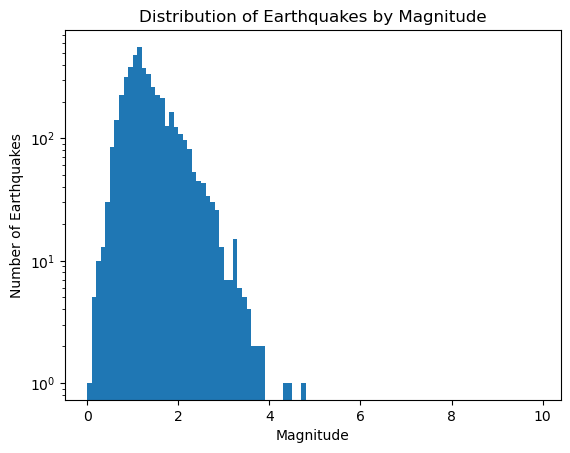

In [4]:
#Isolate magnitudes for further manipulation
#Generate histogram to visualize distribution of magnitudes
mags = eqs['mag'].tolist()
#plt.hist(mags, bins = np.arange(0, 10, 0.1))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(mags, bins = np.arange(0, 10, 0.1))
ax.set_yscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Number of Earthquakes')

plt.title('Distribution of Earthquakes by Magnitude')

In [5]:
#Determine b-value of GR relations of different magnitudes of completeness, going in increments of 0.1
#first Mi is highest mag bin with at least 2 events

#FIND FIRST_MI WHICH IS THE FIRST MAGNITUDE BIN
array_mags = (eqs.loc[:, 'mag']).values
number_of_eqs = len(eqs)
index_of_second_highest = number_of_eqs - 2
first_mi = round(mags[index_of_second_highest] - .1, 1)
first_mi

4.4

/tmp/ipykernel_30/3674338422.py:12: RuntimeWarning: divide by zero encountered in log10
  logs_for_graph = np.log10(eqs_per_mag)


Text(0, 0.5, 'Log Number of Earthquakes')

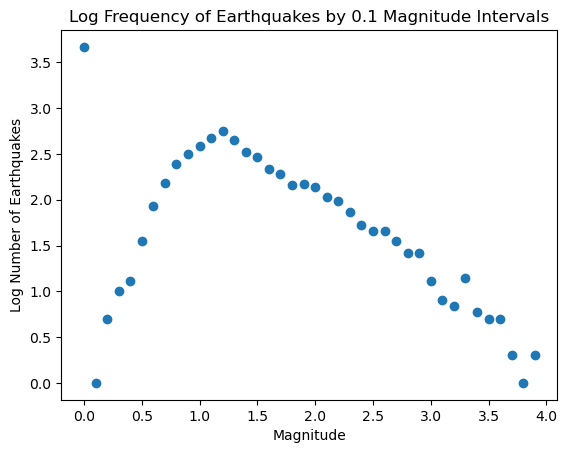

In [6]:
eqs_per_mag = np.array(len(mags)) 
start_min = 0.1
num_iterations = first_mi*10 - 1
for i in np.arange(num_iterations):       
    num_eqs_above_bin_high = np.count_nonzero(start_min < array_mags)
    num_eqs_above_bin_low = np.count_nonzero((start_min - 0.1) <= array_mags)
    eqs_in_bin = num_eqs_above_bin_low - num_eqs_above_bin_high
    eqs_per_mag = np.append(eqs_per_mag, eqs_in_bin)
    start_min = start_min + .1
    
magnitudes_for_graph_test = np.arange(0.0, first_mi, 0.1)
logs_for_graph = np.log10(eqs_per_mag)

#model = LinearRegression().fit(magnitudes_for_graph_test.reshape(-1,1), logs_for_graph)

plt.scatter(magnitudes_for_graph_test, logs_for_graph)
plt.title("Log Frequency of Earthquakes by 0.1 Magnitude Intervals")
plt.xlabel("Magnitude")
plt.ylabel("Log Number of Earthquakes")
#plt.scatter(magnitudes_for_graph_test, eqs_per_mag)
#plt.plot([0,5], [model.intercept_ + (model.coef_ * 0), model.intercept_ + (model.coef_ * 5)], '-r')

In [7]:
df = pd.DataFrame()
df['magnitudes'] = magnitudes_for_graph_test
df['eqs_per_mag'] = eqs_per_mag
df = df.drop(df.index[0])

delta_y = np.diff(df['eqs_per_mag'])
delta_y = np.insert(delta_y, 0, 0)
df['delta_y'] = delta_y
df['slope'] = delta_y/0.1
df['abs_val_slope'] = abs(df['slope'])
df = df.drop(df.index[0])

df.head()

,magnitudes,eqs_per_mag,delta_y,slope,abs_val_slope
2,0.2,5,4,40.0,40.0
3,0.3,10,5,50.0,50.0
4,0.4,13,3,30.0,30.0
5,0.5,35,22,220.0,220.0
6,0.6,85,50,500.0,500.0


In [8]:
# Return
min_mag_row = df.loc[df['abs_val_slope'].idxmax()]
min_mag = min_mag_row[0]
min_mag_abs_val_slope = min_mag_row[4]
min_mag_row

magnitudes          1.3
eqs_per_mag       445.0
delta_y          -114.0
slope           -1140.0
abs_val_slope    1140.0
Name: 13, dtype: float64

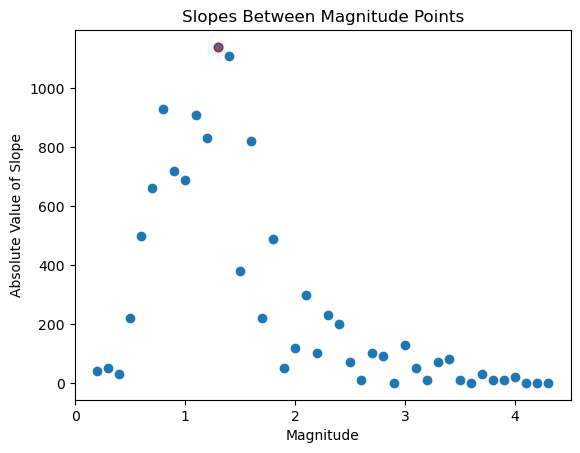

In [9]:
#Plot minimum magnitudes against the absolute value of their instantaneous slope -> max slope = max curvature
plt.scatter(df['magnitudes'], df['abs_val_slope'])
plt.title("Slopes Between Magnitude Points")
plt.xlabel("Magnitude")
plt.ylabel("Absolute Value of Slope")
plt.plot(min_mag, min_mag_abs_val_slope, marker = "o", markeredgecolor = "red")

In [10]:
maximum = max(df['eqs_per_mag'])
maximums = []

for i,row in df.iterrows():
    if row['eqs_per_mag'] == maximum:
        maximums = np.append(maximums, row['magnitudes'])

lowest_maximum = min(maximums)
print(lowest_maximum)

1.2000000000000002


In [14]:
def lik(parameters, x, y): 
    m = parameters[0] 
    b = parameters[1] 
    sigma = parameters[2] 
    
    y_exp = m * x + b 
        
    L = np.sum(np.log(norm.pdf(y - y_exp, loc = 0, scale=sigma)))
    return -L


def constraints(parameters):
    sigma = parameters[2]
    return sigma

cons = {
    'type': 'ineq',
    'fun': constraints
}

/tmp/ipykernel_30/1985538257.py:8: RuntimeWarning: divide by zero encountered in log
  L = np.sum(np.log(norm.pdf(y - y_exp, loc = 0, scale=sigma)))


Text(0.5, 1.0, 'R-Squared = 0.9609802581472039')

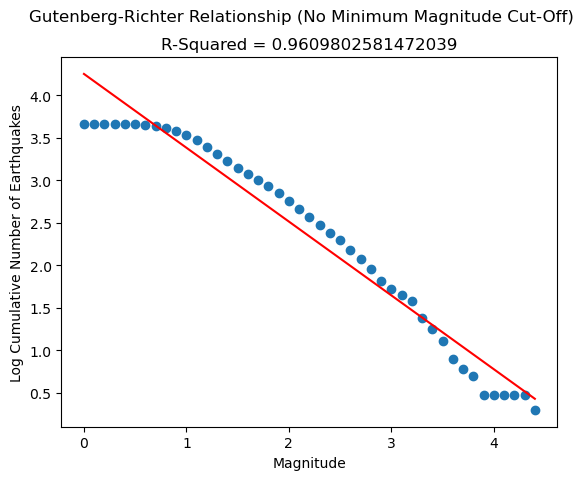

In [102]:
eqs_per_mag_cumulative = np.array(len(mags)) 
start_min = 0.1
num_iterations = first_mi*10
for i in np.arange(num_iterations):     # 0-99 needed to get to 10.0 max magnitude  
    num_eqs_above_bin = np.count_nonzero(start_min <= array_mags) 
    eqs_per_mag_cumulative = np.append(eqs_per_mag_cumulative, num_eqs_above_bin)
    start_min = start_min + .1
    
magnitudes_for_graph_test = np.arange(0.0, first_mi + 0.1, 0.1)
logs_for_graph = np.log10(eqs_per_mag_cumulative)


x = magnitudes_for_graph_test
y = logs_for_graph

lik_model_1 = minimize(lik, np.array([2, 2, 2]), args=(x,y,), constraints=cons)


plt.scatter(magnitudes_for_graph_test, logs_for_graph)
xx = np.linspace(np.min(magnitudes_for_graph_test), np.max(magnitudes_for_graph_test), len(logs_for_graph))
yy = lik_model_1.x[0] * xx +  lik_model_1.x[1]

r_squared = 1 - sum((logs_for_graph - yy)**2) / sum((logs_for_graph - np.mean(logs_for_graph))**2)
r_squared_string = str(r_squared)

plt.plot(xx,yy, 'r-')                        
plt.suptitle("Gutenberg-Richter Relationship (No Minimum Magnitude Cut-Off)")
plt.xlabel("Magnitude")
plt.ylabel("Log Cumulative Number of Earthquakes")
plt.title("R-Squared = " + r_squared_string)

/tmp/ipykernel_30/1985538257.py:8: RuntimeWarning: divide by zero encountered in log
  L = np.sum(np.log(norm.pdf(y - y_exp, loc = 0, scale=sigma)))


Text(0.5, 1.0, 'R-Squared = 0.9912136125064003')

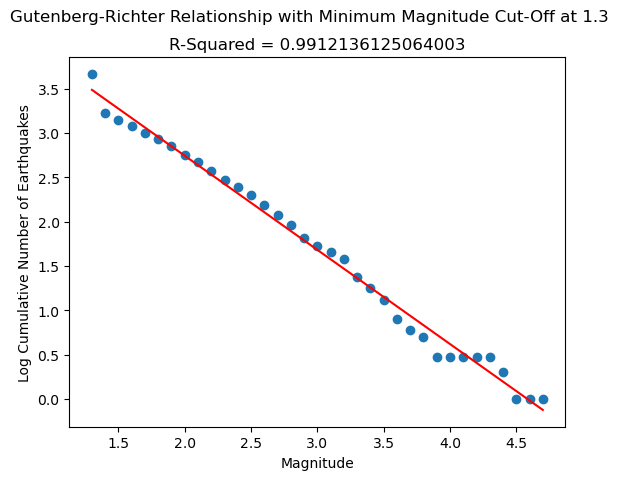

In [103]:
max_mag_rounded = round(max(mags), 1)
eqs_per_mag_cumulative = np.array(len(mags)) 
test_min_mag = min_mag
min_mag_string = str(min_mag)
start_min = 0.1 + test_min_mag
num_iterations = (max_mag_rounded*10) - (test_min_mag*10)
for i in np.arange(num_iterations):     # 0-99 needed to get to 10.0 max magnitude  
    num_eqs_above_bin = np.count_nonzero(start_min <= array_mags) 
    eqs_per_mag_cumulative = np.append(eqs_per_mag_cumulative, num_eqs_above_bin)
    start_min = start_min + .1
    
magnitudes_for_graph_test_2 = np.arange(test_min_mag, test_min_mag + (num_iterations * 0.1) + 0.1 , 0.1)
logs_for_graph_2 = np.log10(eqs_per_mag_cumulative)


x_2 = magnitudes_for_graph_test_2
y_2 = logs_for_graph_2

lik_model_2 = minimize(lik, np.array([2, 2, 2]), args=(x_2,y_2,), constraints=cons)

plt.scatter(magnitudes_for_graph_test_2, logs_for_graph_2)
xx_2 = np.linspace(np.min(magnitudes_for_graph_test_2), np.max(magnitudes_for_graph_test_2), len(logs_for_graph_2))
yy_2 = lik_model_2.x[0] * xx_2 +  lik_model_2.x[1]

r_squared_min_mag = 1 - sum((logs_for_graph_2 - yy_2)**2) / sum((logs_for_graph_2 - np.mean(logs_for_graph_2))**2)
r_squared_min_mag_string = str(r_squared_min_mag)

plt.plot(xx_2,yy_2, 'r-')  
plt.suptitle("Gutenberg-Richter Relationship with Minimum Magnitude Cut-Off at " + min_mag_string)
plt.xlabel("Magnitude")
plt.ylabel("Log Cumulative Number of Earthquakes")
plt.title("R-Squared = " + r_squared_min_mag_string)